# Problem Statement

[An article in the Dallas Observer](https://www.dallasobserver.com/restaurants/dallas-restaurant-inspections-suffer-from-delays-poor-record-keeping-and-overworked-staff-10697588) unearthed a massive problem in the city's ability to follow up on restaurants requiring reinspection due to a low grade upon original inspection.  Dallas states that out of a scale from 1-100, any facility that scores between 70-79 requires reinspection within 30 days, between 60-69 requires reinspection within 10 days, and below 60 requires reinspection ASAP.

The article points out many flaws in the city's ability to reinspect restaurants within its own self-imposed timeframes,.  Until the department can hopefully become better-staffed, I am looking to build a classification model that can predict how a restaurant will perform upon reinspection.  This way, if the city is still struggling to reinspect restaurants in a timely manner, they can refer to the model in order to prioritize certain facilities to reinspect.



In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

In [108]:
df = pd.read_csv('./data/Restaurant_and_Food_Establishment_Inspections__October_2016_to_Present_.csv')

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,97,103,105,106,107,109,110) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [109]:
df.head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
0,FRESHII,Routine,10/31/2018,96,2414,VICTORY PARK,NaN,LN,NaN,2414 VICTORY PARK LN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2018,FY2019,"2414 VICTORY PARK LN\n(32.787625, -96.809294)"
1,MICKLE CHICKEN,Routine,10/30/2019,100,3203,CAMP WISDOM,W,RD,NaN,3203 W CAMP WISDOM RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2019,FY2020,"3203 W CAMP WISDOM RD\n(32.662584, -96.873446)"
2,WORLD TRADE CENTER MARKET,Routine,11/03/2016,100,2050,STEMMONS,N,FRWY,NaN,2050 N STEMMONS FRWY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2016,FY2017,"2050 N STEMMONS FRWY\n(32.801934, -96.825878)"
3,DUNKIN DONUTS,Routine,10/30/2019,99,8008,HERB KELLEHER,NaN,WAY,C2174,8008 HERB KELLEHER WAY STE# C2174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2019,FY2020,8008 HERB KELLEHER WAY STE# C2174
4,CANVAS HOTEL - 6TH FLOOR,Routine,06/11/2018,100,1325,LAMAR,S,ST,NaN,1325 S LAMAR ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"1325 S LAMAR ST\n(39.69335, -105.067425)"


In [110]:
df.isnull().sum()

Restaurant Name             11
Inspection Type              0
Inspection Date              0
Inspection Score             0
Street Number                0
                         ...  
Violation Detail - 25    44654
Violation Memo - 25      44653
Inspection Month             0
Inspection Year              0
Lat Long Location            0
Length: 114, dtype: int64

Since this project is based on NLP, I will be merging all of the violation detail, description, and memo columns, which should handle the nulls.  Any leftover nulls after that merge likely relate to a restaurant having no violations to note, which is important data.  11 restaurant names are null.  If there is an address given, I will probably keep them.  Additionally, I will merge the address columns with names to help the model account for different locations of the same restaurant.

In [111]:
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])

In [112]:
df.shape

(44656, 114)

In [113]:
df.loc[df['Restaurant Name'].isnull()]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
20592,NaN,Routine,2018-02-21,86,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
21643,NaN,Routine,2017-08-28,87,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
24064,NaN,Routine,2017-07-28,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul 2017,FY2017,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
24612,NaN,Routine,2018-08-06,91,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
26713,NaN,Routine,2017-02-02,88,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
33050,NaN,Routine,2017-11-27,80,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2017,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
34370,NaN,Routine,2018-06-13,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
39616,NaN,Routine,2018-05-22,92,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43261,NaN,Routine,2017-05-31,91,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2017,FY2017,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43934,NaN,Routine,2018-01-03,84,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"


In [204]:
df.loc[df['Street Number'] == 4243]

,index,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,...,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,inspection_count
4723,26713,NaN,Routine,2017-02-02,88,4243,WESTMORELAND,S,RD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)",2
12344,21643,NaN,Routine,2017-08-28,87,4243,WESTMORELAND,S,RD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)",5
19138,20592,NaN,Routine,2018-02-21,86,4243,WESTMORELAND,S,RD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)",8
25707,24612,NaN,Routine,2018-08-06,91,4243,WESTMORELAND,S,RD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)",11
32891,14015,WILLIAMS CHICKEN,Routine,2019-02-11,97,4243,WESTMORELAND,S,RD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2019,FY2019,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)",1
37960,4333,WILLIAMS CHICKEN,Routine,2019-08-14,94,4243,WESTMORELAND,S,RD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2019,FY2019,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)",2
43149,10552,WILLIAMS CHICKEN,Routine,2020-02-12,92,4243,WESTMORELAND,S,RD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2020,FY2020,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)",1


The NaN restaurants could refer to a previous restaurant at the same location, so I may want to avoid imputation.

In [115]:
df.loc[df['Street Number'] == 8686]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
339,DONUT TOWN,Routine,2018-11-23,98,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2018,FY2019,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
32431,DONUT TOWN,Routine,2018-05-22,92,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
33050,NaN,Routine,2017-11-27,80,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2017,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
39616,NaN,Routine,2018-05-22,92,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43261,NaN,Routine,2017-05-31,91,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2017,FY2017,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"


In [116]:
df.loc[df['Street Number'] == 6449]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
8299,FRANKIE'S FOOD MART,Routine,2019-12-09,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec 2019,FY2020,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
17424,FRANKIE'S FOOD MART,Routine,2018-12-04,81,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec 2018,FY2019,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
24064,NaN,Routine,2017-07-28,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul 2017,FY2017,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
34370,NaN,Routine,2018-06-13,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
43934,NaN,Routine,2018-01-03,84,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
44450,NaN,Routine,2016-12-20,88,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec 2016,FY2017,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"


In [117]:
df.loc[df[df.columns[3:]].duplicated()].sort_values(by = "Inspection Date")

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
19659,ONE MAIN PLACE LEVEL B1 KITCHEN,Routine,2016-10-06,100,1201,MAIN,NaN,ST,NaN,1201 MAIN ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"1201 MAIN ST\n(41.024999, -81.430786)"
26891,ONE MAIN PLACE 2nd FLOOR BAR,Routine,2016-10-06,100,1201,MAIN,NaN,ST,NaN,1201 MAIN ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"1201 MAIN ST\n(41.024999, -81.430786)"
7273,LIFE CHARTER SCHOOL,Routine,2016-10-25,100,4400,RL THORNTON,S,FRWY,NaN,4400 S RL THORNTON FRWY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"4400 S RL THORNTON FRWY\n(32.691296, -96.822673)"
9049,FIESTA MART #74 BAKERY,Routine,2016-10-26,100,11445,GARLAND,NaN,RD,NaN,11445 GARLAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"11445 GARLAND RD\n(32.850702, -96.681525)"
13715,BAYLOR UNIVERSITY MED CTR DISHROOM,Routine,2016-10-26,100,3500,GASTON,NaN,AVE,NaN,3500 GASTON AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"3500 GASTON AVE\n(32.342322, -86.31818)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041,CC YOUNG (ADULT DAY CARE LEVEL 1),Routine,2020-04-03,100,4849,LAWTHER,W,DR,NaN,4849 W LAWTHER DR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr 2020,FY2020,"4849 W LAWTHER DR\n(32.85442, -96.730528)"
8624,CC YOUNG LEVEL 7 (SKILLED NURSING CAFE),Routine,2020-04-03,100,4849,LAWTHER,W,DR,NaN,4849 W LAWTHER DR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr 2020,FY2020,"4849 W LAWTHER DR\n(32.85442, -96.730528)"
6979,CC YOUNG LEVEL 8 (SKILLED NURSING CAFE),Routine,2020-04-03,100,4849,LAWTHER,W,DR,NaN,4849 W LAWTHER DR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr 2020,FY2020,"4849 W LAWTHER DR\n(32.85442, -96.730528)"
6998,TOM THUMB-BAKERY,Routine,2020-04-08,100,2380,FIELD,N,ST,NaN,2380 N FIELD ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr 2020,FY2020,"2380 N FIELD ST\n(32.78904, -96.806882)"


In [118]:
df = df.sort_values(by = 'Inspection Date')

In [119]:
df.reset_index(inplace = True)

In [120]:
df['Inspection Type'].value_counts()

Routine      43990
Follow-up      641
Complaint       25
Name: Inspection Type, dtype: int64

In [121]:
follow_ups_df = df.loc[df['Inspection Type'] == 'Follow-up']

In [122]:
restaurants = list(follow_ups_df['Restaurant Name'])

In [123]:
follow_ups_df

,index,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
51,21062,THAI THAI,Follow-up,2016-10-05,82,1731,GREENVILLE,NaN,AVE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"1731 GREENVILLE AVE\n(32.812007, -96.770206)"
62,18705,TOMORROW SEAFOOD & CHICKEN,Follow-up,2016-10-05,90,3200,LANCASTER,S,RD,#742A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"3200 S LANCASTER RD #742A\n(32.708127, -96.801..."
140,44578,ZENNA,Follow-up,2016-10-07,80,3950,ROSEMEADE,NaN,PKWY,#100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"3950 ROSEMEADE PKWY #100\n(33.010437, -96.84581)"
141,29436,POPEYES,Follow-up,2016-10-07,94,18311,MARSH,NaN,LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"18311 MARSH LN\n(32.999855, -96.855923)"
145,18296,RAVENNA,Follow-up,2016-10-10,85,115,FIELD,S,ST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"115 S FIELD ST\n(33.235904, -96.795985)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43981,4077,TAQUERIA'S ROJAS,Follow-up,2020-03-09,80,1328,JIM MILLER,N,RD,#101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar 2020,FY2020,"1328 N JIM MILLER RD #101\n(32.73556, -96.700079)"
43992,3261,LITTLE KATANA,Follow-up,2020-03-09,80,4525,COLE,NaN,AVE,#160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar 2020,FY2020,"4525 COLE AVE #160\n(32.822383, -96.789342)"
44129,8631,FRUTERIA Y NIEVERIA COCO'S,Follow-up,2020-03-16,88,6212,SAMUELL,NaN,BLVD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar 2020,FY2020,"6212 SAMUELL BLVD\n(32.792147, -96.698279)"
44230,7131,RESTAURANT LEYLITA #2,Follow-up,2020-03-19,86,2330,ROYAL,NaN,LN,#600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar 2020,FY2020,"2330 ROYAL LN #600\n(32.895564, -96.900756)"


In [158]:
follow_ups_df['Restaurant Name']

51                        THAI THAI
62       TOMORROW SEAFOOD & CHICKEN
140                           ZENNA
141                         POPEYES
145                         RAVENNA
                    ...            
43981              TAQUERIA'S ROJAS
43992                 LITTLE KATANA
44129    FRUTERIA Y NIEVERIA COCO'S
44230         RESTAURANT LEYLITA #2
44555       KNOCKOUT SPORTS BAR LLC
Name: Restaurant Name, Length: 641, dtype: object

In [166]:
fol_up_list = [i.replace(",", "") for i in follow_ups_df['Restaurant Name']]


In [197]:
df.loc[df['Restaurant Name'].isin(fol_up_list)]

,index,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
1,14666,TORTAS Y TACOS EL RANCHITO #4,Routine,2016-10-03,83,5560,GRAND,E,AVE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"5560 E GRAND AVE\n(32.793596, -96.747508)"
4,24725,HENDERSON CHICKEN,Routine,2016-10-03,80,1328,JIM MILLER,N,RD,#108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"1328 N JIM MILLER RD #108\n(32.73556, -96.700079)"
18,30812,EL POLLO REGIO,Routine,2016-10-04,78,2716,DAVIS,W,ST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"2716 W DAVIS ST\n(32.749506, -96.863021)"
27,14053,FRUTERIA Y NIEVERIA COCO'S,Routine,2016-10-04,84,6212,SAMUELL,NaN,BLVD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"6212 SAMUELL BLVD\n(32.792147, -96.698279)"
42,23099,GOLDEN CHICK,Routine,2016-10-05,86,3071,NORTHWEST,W,HWY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"3071 W NORTHWEST HWY\n(32.85517, -96.869116)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44611,8516,MCDONALD'S,Routine,2020-04-07,96,2551,GUS THOMASSON,NaN,RD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr 2020,FY2020,"2551 GUS THOMASSON RD\n(32.834876, -96.671466)"
44623,7270,SUBWAY SANDWICHES,Routine,2020-04-08,93,6813,NORTHWEST,W,HWY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr 2020,FY2020,"6813 W NORTHWEST HWY\n(32.865594, -96.788125)"
44640,8701,POPEYES,Routine,2020-04-09,94,3561,FOREST,NaN,LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr 2020,FY2020,"3561 FOREST LN\n(32.90964, -96.859792)"
44649,8539,7-ELEVEN CONVENIENCE STORE #38039A,Routine,2020-04-13,82,2990,OLIVE,NaN,ST,#180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr 2020,FY2020,"2990 OLIVE ST #180\n(39.759904, -104.906923)"


In [206]:
df['inspection_count'] = df.groupby(['Restaurant Name', 'Street Address','Inspection Year']).cumcount()+1

In [207]:
df['inspection_count'].value_counts()

1     26571
2     16038
3      1704
4       249
5        62
6        17
7         7
8         3
10        2
9         2
11        1
Name: inspection_count, dtype: int64

In [210]:
df.loc[df['inspection_count'] == 9]

,index,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,...,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,inspection_count
22709,39616,NaN,Routine,2018-05-22,92,8686,FERGUSON,NaN,RD,#210,...,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)",9
25126,44540,MAMA'S DAUGHTER'S DINER,Routine,2018-07-20,71,2610,ROYAL,NaN,LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Jul 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",9


In [211]:
df.loc[df['Restaurant Name'] == "MAMA'S DAUGHTER'S DINER"]

,index,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,...,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,inspection_count
3754,14643,MAMA'S DAUGHTER'S DINER,Routine,2017-01-10,95,2610,ROYAL,NaN,LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Jan 2017,FY2017,"2610 ROYAL LN\n(32.446632, -97.701097)",1
4770,35436,MAMA'S DAUGHTER'S DINER,Routine,2017-02-06,85,2014,IRVING,NaN,BLVD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2017,FY2017,"2014 IRVING BLVD\n(32.795151, -96.828667)",1
10415,17342,MAMA'S DAUGHTER'S DINER,Routine,2017-06-30,89,2610,ROYAL,NaN,LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2017,FY2017,"2610 ROYAL LN\n(32.446632, -97.701097)",2
12022,37808,MAMA'S DAUGHTER'S DINER,Routine,2017-08-16,86,2014,IRVING,NaN,BLVD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2017,FY2017,"2014 IRVING BLVD\n(32.795151, -96.828667)",2
16941,14795,MAMA'S DAUGHTER'S DINER,Routine,2017-12-22,67,2610,ROYAL,NaN,LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Dec 2017,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",1
17696,17663,MAMA'S DAUGHTER'S DINER,Routine,2018-01-16,75,2610,ROYAL,NaN,LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Jan 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",2
18059,41987,MAMA'S DAUGHTER'S DINER,Routine,2018-01-24,69,2610,ROYAL,NaN,LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Jan 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",3
18597,35315,MAMA'S DAUGHTER'S DINER,Routine,2018-02-07,73,2610,ROYAL,NaN,LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",4
18776,40808,MAMA'S DAUGHTER'S DINER,Routine,2018-02-10,90,2014,IRVING,NaN,BLVD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"2014 IRVING BLVD\n(32.795151, -96.828667)",1
19716,36473,MAMA'S DAUGHTER'S DINER,Routine,2018-03-07,63,2610,ROYAL,NaN,LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Mar 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",5


In [203]:
df.loc[(df['Restaurant Name'] == "EL POLLO REGIO") & (df['Street Number'] == 2716) ,['Restaurant Name', 'Inspection Type','Inspection Date','Inspection Score','Street Number','Street Name','Inspection Year', 'inspection_count']]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Inspection Year,inspection_count
18,EL POLLO REGIO,Routine,2016-10-04,78,2716,DAVIS,FY2017,1
2321,EL POLLO REGIO,Follow-up,2016-12-02,93,2716,DAVIS,FY2017,2
10345,EL POLLO REGIO,Routine,2017-06-29,72,2716,DAVIS,FY2017,3
14661,EL POLLO REGIO,Complaint,2017-10-27,80,2716,DAVIS,FY2018,1
22174,EL POLLO REGIO,Routine,2018-05-07,87,2716,DAVIS,FY2018,2
27914,EL POLLO REGIO,Routine,2018-10-02,88,2716,DAVIS,FY2019,1
35113,EL POLLO REGIO,Routine,2019-04-22,92,2716,DAVIS,FY2019,2
39992,EL POLLO REGIO,Routine,2019-10-31,88,2716,DAVIS,FY2020,1
44654,EL POLLO REGIO,Routine,2020-04-14,91,2716,DAVIS,FY2020,2


In [164]:
res_list_plus_or

['THAI THAI',
 'TOMORROW SEAFOOD & CHICKEN',
 'ZENNA',
 'POPEYES',
 'RAVENNA',
 "DICKEY'S BARBEQUE PIT",
 'RALPHBOY',
 "CAMPISI'S PIZZA",
 'SUSHI YA RESTAURANT',
 "THE MEN'S CLUB",
 'REFUL',
 'CHARLIES CREOLE KITCHEN',
 'SMOOTHIE FACTORY',
 'SMOOTHIE FACTORY',
 'GREEK ISLES OF DALLAS',
 'SUSHI STAR',
 'HENDERSON TAP HOUSE',
 'CASA MAMA COMIDA CASERA',
 'VBC GREENVILLE',
 "SNUFFER'S",
 'EL POLLO REGIO',
 'CAFE HERRERA',
 'DRUGSTORE COWBOY',
 'TANOSHI RAMEN',
 'JENAS ALLGOOD CAFE',
 'CAFE SALSEPA',
 'SOL IRLANDES',
 'PHO BOWL',
 'SOUTHSIDE STEAKS & CAKES',
 'CANVAS HOTEL - KITCHEN AREA 1ST FL',
 'TACOS EL PATRON',
 'LG TAPS',
 'KNUCKLE SANDWICH COMPANY',
 'UNO MAS',
 'THE PROPHET KITCHEN',
 "LENNY'S SUB SHOP",
 'EL FENIX',
 "CAMPISI'S PIZZA",
 'VBC GREENVILLE',
 'RIO BRAVO BAR & RESTAURANT SEAFOOD & BAR INC',
 'LA CALLE DOCE IN LAKEWOOD',
 'GENGHIS GRILL',
 'CELEBRITY CAFE & BAKERY',
 'COFFEE HOUSE CAFE',
 'LAKEWEST REHABILITATION AND',
 'TAQUERIA LA VICTORIA',
 'GOOD TIME FOOD MART',
 '

In [152]:
res_list_plus_or.s.replace(',', '')

AttributeError: 'list' object has no attribute 's'

# EDA

In [171]:
follow_ups_df

,index,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
51,21062,THAI THAI,Follow-up,2016-10-05,82,1731,GREENVILLE,NaN,AVE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"1731 GREENVILLE AVE\n(32.812007, -96.770206)"
62,18705,TOMORROW SEAFOOD & CHICKEN,Follow-up,2016-10-05,90,3200,LANCASTER,S,RD,#742A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"3200 S LANCASTER RD #742A\n(32.708127, -96.801..."
140,44578,ZENNA,Follow-up,2016-10-07,80,3950,ROSEMEADE,NaN,PKWY,#100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"3950 ROSEMEADE PKWY #100\n(33.010437, -96.84581)"
141,29436,POPEYES,Follow-up,2016-10-07,94,18311,MARSH,NaN,LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"18311 MARSH LN\n(32.999855, -96.855923)"
145,18296,RAVENNA,Follow-up,2016-10-10,85,115,FIELD,S,ST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2016,FY2017,"115 S FIELD ST\n(33.235904, -96.795985)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43981,4077,TAQUERIA'S ROJAS,Follow-up,2020-03-09,80,1328,JIM MILLER,N,RD,#101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar 2020,FY2020,"1328 N JIM MILLER RD #101\n(32.73556, -96.700079)"
43992,3261,LITTLE KATANA,Follow-up,2020-03-09,80,4525,COLE,NaN,AVE,#160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar 2020,FY2020,"4525 COLE AVE #160\n(32.822383, -96.789342)"
44129,8631,FRUTERIA Y NIEVERIA COCO'S,Follow-up,2020-03-16,88,6212,SAMUELL,NaN,BLVD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar 2020,FY2020,"6212 SAMUELL BLVD\n(32.792147, -96.698279)"
44230,7131,RESTAURANT LEYLITA #2,Follow-up,2020-03-19,86,2330,ROYAL,NaN,LN,#600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar 2020,FY2020,"2330 ROYAL LN #600\n(32.895564, -96.900756)"


{'whiskers': [<matplotlib.lines.Line2D at 0x1a2909f8d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a290a7350>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2909f390>],
 'medians': [<matplotlib.lines.Line2D at 0x1a290a7dd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a29175350>],
 'means': []}

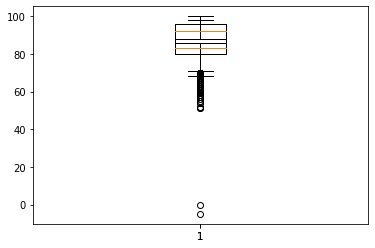

In [175]:
plt.boxplot(follow_ups_df['Inspection Score'])
plt.boxplot(df.loc[df['Inspection Type'] == 'Routine']['Inspection Score'])

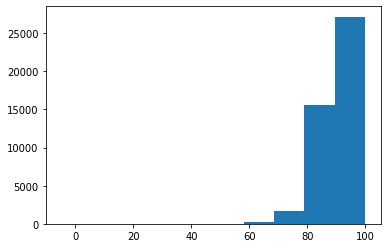

In [182]:
plt.hist(df['Inspection Score'], bins = 10);

In [188]:
len(df.loc[df['Inspection Score'] >= 80]) / len(df)

0.9542726621282694

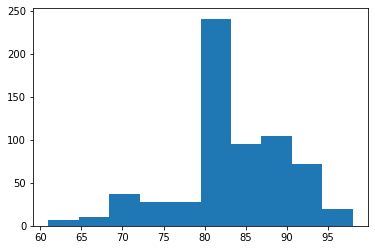

In [181]:
plt.hist(follow_ups_df['Inspection Score'], bins = 10);

In [189]:
len(follow_ups_df.loc[follow_ups_df['Inspection Score'] >= 80]) / len(follow_ups_df)

0.828393135725429

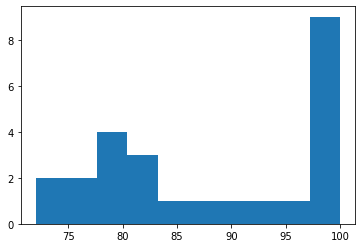

In [186]:
plt.hist(df.loc[df['Inspection Type'] == 'Complaint']['Inspection Score']);


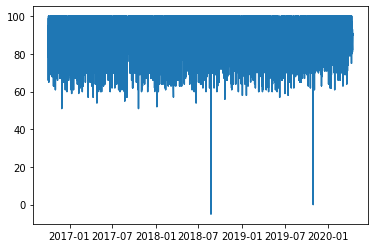

In [193]:
plt.plot(df['Inspection Date'], df['Inspection Score'])

In [196]:
len(df.loc[df['Inspection Score'] < 80])

2042

In [67]:
# Filter on follow-up only
# Match them with their routine
# put them side by side

# add success metric and models to problem statement
# finish EDA

In [ ]:
follo